Danny Abraham
<center><h1>CMPS 351</h1></center>
<center><h2>Assignment 3</h2></center>

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

## Minimal Surface
---
#### Surface Area

In [2]:
def surface_area(x, n = 20, r0 = 1, l = 0.75):
    # compute the distance between radii h
    h = l / (n + 1)
    
    # initialize the vectors used
    a = np.append(x, r0)
    b = np.append(r0, x)
    c = np.append(x[0], x)
    
    f = 2*np.pi*h*c*(1 + ((a - b) / h)**2)**0.5
    return np.sum(f)

#### Gradient

In [3]:
def surface_area_gradient(x, n = 20, r0 = 1, l = 0.75):
    # compute the distance between radii h
    h = l / (n + 1)
    
    # initialize the vectors used
    a = np.append(r0, x[:-1])
    c = np.append(x[1:], r0)
    
    t1 = 2*np.pi*h*a*( ((x - a) / h**2) / ((1 + ((x - a) / h)**2)**0.5) )
    t2 = 2*np.pi*h*((1 + ((c - x) / h)**2)**0.5)
    t3 = 2*np.pi*h*x*( ((c - x) / h**2) / ((1 + ((c - x) / h)**2)**0.5) )
    
    t = t1 + t2 - t3
    t[0] += 2*h*np.pi*((r0 - x[0])**2/h**2 + 1)**(1/2)
    return t

#### Hessian

In [4]:
def tridiag(a, b, c, k1 = -1, k2 = 0, k3 = 1):
    return np.diag(b, k2) + np.diag(a, k1) + np.diag(c, k3)

In [5]:
def surface_area_hessian(x, n = 20, r0 = 1, l = 0.75):
    # compute the distance between radii h
    h = l / (n + 1)
    
    # initialize the vectors used
    k = np.append(x[0],x[0:-1])
    y = np.append(x[1:],r0)
    z = np.append(r0,x[0:-1])
    
    diag  = 4*np.pi*(x - y)/(h*(((x-y)/h)**2+1)**0.5)
    diag += 2*np.pi*k/(h*(((z-x)/h)**2+1)**0.5)
    diag += 2*np.pi*x/(h*(((x-y)/h)**2+1)**0.5)
    diag -= 2*np.pi*k*(z-x)**2/(h**3*(((z-x)/h)**2+1)**1.5)
    diag -= 2*np.pi*x*(x-y)**2/(h**3*(((x-y)/h)**2+1)**1.5)
    diag[0] += 4*np.pi*(x[0]-r0)/(h*(1+((x[0]-r0)/h)**2)**0.5)
    
    temp = 2*np.pi*x[0:-1]*(x[0:-1]-y[0:-1])**2/(h**3*(((x[0:-1]-y[0:-1])/h)**2+1)**1.5)
    temp -= 2*np.pi*x[0:-1]/(h*(((x[0:-1]-y[0:-1])/h)**2+1)**0.5)
    temp += 2*np.pi*(y[0:-1]-x[0:-1])/(h*(((x[0:-1]-y[0:-1])/h)**2+1)**0.5)
    
    hess = tridiag(temp, diag, temp)
    return hess

####  Backtrack Line Search

In [6]:
def backtrack_linesearch(f, gk, pk, xk, alpha = 0.01, beta = 0.6):
    t = 1
    while ( f(xk + t*pk) > f(xk) + alpha*t*gk@pk):
        t *= beta
    return t

#### Newton Backtrack

In [7]:
def newton_backtrack(f, grad, hess, x0, tol = 1e-5):
    x = x0
    history = np.array([x0])
    while (la.norm(grad(x)) > tol):
        #print(la.norm(grad(x)))
        p = la.solve(hess(x), -grad(x))
        t = backtrack_linesearch(f, grad(x), p, x)
        x += t * p
        history = np.vstack((history, x))
    return x, history

#### Plotting the Performance

In [8]:
x0 = np.ones(20)
xstar, history = newton_backtrack(surface_area, 
                                  surface_area_gradient, 
                                  surface_area_hessian, 
                                  x0)

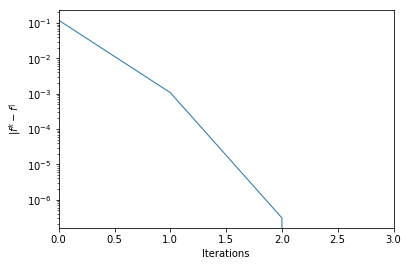

In [9]:
nsteps = history.shape[0]
fhist = np.zeros(nsteps)
fstar = surface_area(xstar)

for i in range(nsteps):
    fhist[i] = surface_area(history[i,:])
    
plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
plt.semilogy(np.arange(0, nsteps), abs(fhist - fstar), linewidth=1)
plt.xlabel('Iterations')
plt.ylabel(r'$|f^k - f^|$')
plt.show()

## Gauss-Newton
---
#### Visualizing the distribution

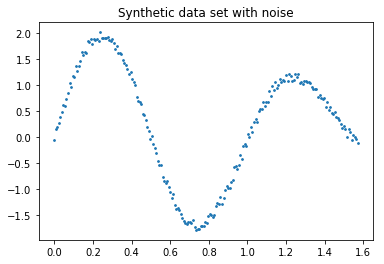

In [10]:
m = 200
t = np.linspace(0, np.pi / 2, m)
p = lambda t: 0.8*np.sin(2*np.pi*1.15*t) + 1.2*np.sin(2*np.pi*0.9*t)
noise = 0.2*np.random.uniform(-0.5, 0.5, m)
y= p(t) + noise
plt.scatter(t, y, s = 3)
plt.title('Synthetic data set with noise')
plt.show()

#### Phi function

In [11]:
def phi(a, t):
    f = a[0]*np.sin(2*np.pi*a[1]*t) + a[2]*np.sin(2*np.pi*a[3]*t)
    return f

#### Residual function

In [12]:
def residual_function(a, t, y):
    o = phi(a, t) - y
    return o

#### Sum of Squares

In [13]:
def sum_squares(a, t, y):
    r = residual_function(a, t, y)
    return 0.5*r@r

#### Jacobian of Objective function

In [14]:
def obj_jacobian(a, t):
    v1 = np.sin(2*np.pi*a[1]*t)
    v2 = 2*np.pi*t*a[0]*np.cos(2*np.pi*a[1]*t)
    v3 = np.sin(2*np.pi*a[3]*t)
    v4 = 2*np.pi*t*a[2]*np.cos(2*np.pi*a[3]*t)   
    return np.array([v1, v2, v3, v4]).transpose()

#### Gradient of Objective function

In [15]:
def obj_gradient(a, t, y):
    return np.dot(obj_jacobian(a, t).transpose(), residual_function(a, t, y))

#### Hessian Approximation
Newton Gauss approximation of Hessian

In [16]:
def hessian_approx(a, t):
    return np.dot(obj_jacobian(a, t).transpose(), obj_jacobian(a,t))

#### Backrack Line Search

In [17]:
def backtrack_linesearch(f, gk, pk, xk, t, y, alpha = 0.01, beta = 0.6):
    t2 = 1
    while ( f(xk + t2*pk, t, y) > f(xk, t, y) + alpha*t2*gk@pk):
        t2 *= beta
    return t2

#### Newton Backtrack

In [18]:
def newton_backtrack(f, grad, hess, a0, t, y, tol = 1e-5):
    a = a0
    history = np.array([a0])
    while (la.norm(grad(a, t, y)) > tol):
        p = la.solve(hess(a, t), -grad(a, t, y))
        t2 = backtrack_linesearch(f, grad(a, t, y), p, a, t, y)
        a += t2 * p
        history = np.vstack((history, a))
    return a, history

#### Plotting the Performance

In [19]:
a0 = np.array([1.1, 0.9, 0.9, 1.1])
astar, history = newton_backtrack(sum_squares,
                                  obj_gradient,
                                  hessian_approx,
                                  a0,
                                  t, 
                                  y)

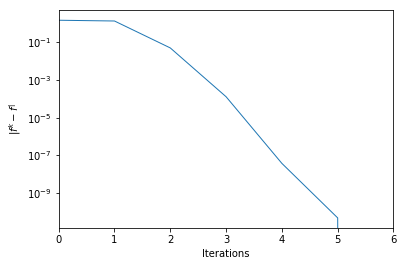

In [20]:
nsteps = history.shape[0]
fhist = np.zeros(nsteps)
fstar = sum_squares(astar, t, y)

for i in range(nsteps):
    fhist[i] = sum_squares(history[i,:], t, y)
    #print(fhist[i])
    
plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
plt.semilogy(np.arange(0, nsteps), abs(fhist - fstar), linewidth=1)
plt.xlabel('Iterations')
plt.ylabel(r'$|f^k - f^|$')
plt.show()

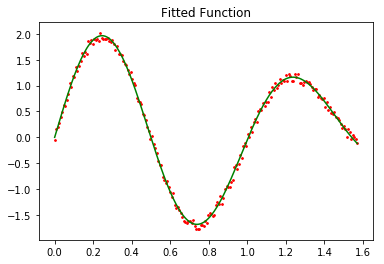

In [21]:
z = phi(astar, t)
plt.plot(t, z, color='green')
plt.scatter(t, y, s = 3, color = 'red')
plt.title('Fitted Function')
plt.show()

## Quasi-Newton Methods
---
The objective of this formula is to mitigate the drawbacks of Newton's method. The largest computation cost of Newton's method is the decomposition of the Hessian. With the BFGS method, the hessian is computed once, and then low cost updates are made to it using the information gained about the hessian from the variations of the gradients.

#### Rosenbrock

In [22]:
def rosenbrock(x):
    f = 10 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    return f

#### Rosenbrock Gradient

In [23]:
def rosenbrock_gradient(x):
    g = np.zeros(2)
    g[0] = -40*x[0]*(x[1] - x[0]**2) + 2*x[0] - 2
    g[1] = 20*x[1] - 20*x[0]**2
    return g

#### Rosenbrock Hessian

In [24]:
def rosenbrock_hessian(x):
    h = np.array([np.zeros(2), np.zeros(2)])
    h[0, 0] = 120*x[0]**2 - 40*x[1] + 2
    h[0, 1] = -40*x[0]
    h[1, 0] = -40*x[0]
    h[1, 1] = 20
    return h

#### Backtrack Line Search

In [25]:
def backtrack_linesearch(f, gk, pk, xk, alpha = 0.01, beta = 0.6):
    t = 1
    while ( f(xk + t*pk) > f(xk) + alpha*t*gk@pk):
        t *= beta
    return t

#### Quasi Newton Backtrack

In [26]:
def bfgs(B, sk, yk):
    B_new = B + (np.dot(sk, yk) + np.dot(np.dot(yk, B), yk))*np.outer(sk, sk)/(sk@yk)**2
    B_new -= ( B@np.outer(yk, sk)+np.outer(sk, yk)@B ) / (sk@yk)
    return B_new

In [27]:
def quasi_newton_backtrack(f, grad, hess, x0, tol = 1e-5):
    x = x0
    gk = grad(x)
    Bk_inv = la.inv(hess(x0))
    history = np.array([x0])
    while (la.norm(grad(x)) > tol):
        g = grad(x)
        #print(Bk_inv)
        p = np.dot(Bk_inv, -g)
        t = backtrack_linesearch(f, g, p, x)
        Bk_inv = bfgs(Bk_inv, t*p, grad(x + t*p) - g)
        x += t * p
        history = np.vstack((history, x))
    return x, history

#### Plotting the Performance

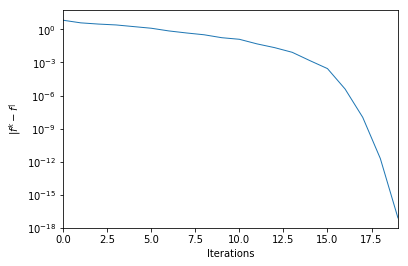

In [28]:
x0 = np.array([-1.2, 1.0])
xstar, history = quasi_newton_backtrack(rosenbrock, rosenbrock_gradient, rosenbrock_hessian, x0)

nsteps = history.shape[0]
fhist = np.zeros(nsteps)

for i in range(nsteps):
    fhist[i] = rosenbrock(history[i,:])
    
plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
plt.semilogy(np.arange(0, nsteps), fhist, linewidth=1)
plt.xlabel('Iterations')
plt.ylabel(r'$|f^k - f^|$')
plt.show()

This Quasi-Newton BFGS method converged in just under 20 iterations. This is far closer to the Newton method's 10 than it is to the Steepest Descent's 1000. As expected getting the exact hessian is not critical to the convergence of the algorithm